# Krypton Lifetime maps

## Compute 

- Single Time Map (STM) of high resolution in XY, using runs 6350-6353
- RPHI mpas in time series computed on the energy-corrected energy

### Author:  JJGC

#### STM maps

-Uses about 4 M events (runs out of memory in MAC for larger sample)
-Compute a single-time map which can then be used to correct geometry

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri Oct 26 16:21:13 2018


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2018-10-26 16:21:13,711 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

#input_file_names  = ['dst_6347_trigger1_0000_9672.h5',
#                     'dst_6348_trigger1_0000_9488.h5',
#                     'dst_6349_trigger1_0000_9562.h5',
#                    'dst_6350_trigger1_0000_9564.h5',
#                     'dst_6351_trigger1_0000_9580.h5',
#                    'dst_6352_trigger1_0000_9838.h5',
#                     'dst_6353_trigger1_0000_9453.h5']

input_file_names  = ['dst_6350_trigger1_0000_9564.h5',
                     'dst_6351_trigger1_0000_9580.h5',
                     'dst_6352_trigger1_0000_9838.h5',
                     'dst_6353_trigger1_0000_9453.h5']

time_bins = 25
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_6350_6353.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_6350_6353.h5'
emap_file_name    = 'kr_emap_xy_50_50_r_6350_6353.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [13]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [14]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [15]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [16]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName


In [17]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_alpha_map
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [18]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [19]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [20]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [21]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [22]:
import krcal.dev.corrections       as corrections 


In [23]:
from numpy import pi, sqrt

In [24]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [25]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [26]:
log = logging.getLogger()

### Input/output 

In [27]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [28]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6350_trigger1_0000_9564.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6351_trigger1_0000_9580.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6352_trigger1_0000_9838.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6353_trigger1_0000_9453.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_6350_6353.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_5_8_ts_25_6350_6353.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_50_50_r_6350_6353.h5')

In [29]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [30]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 3938450


In [31]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [32]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [33]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [34]:
dst = dst[in_range(dst.R, 0, RMAX)]

In [35]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [36]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

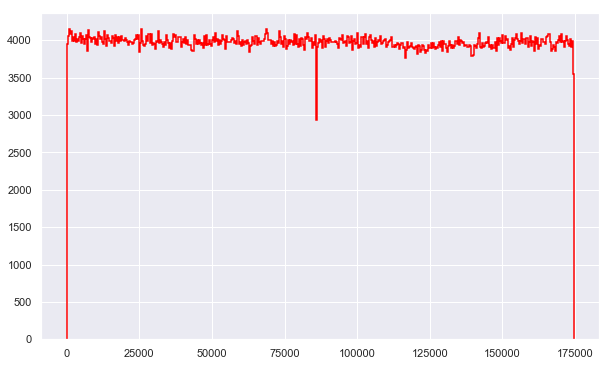

In [37]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

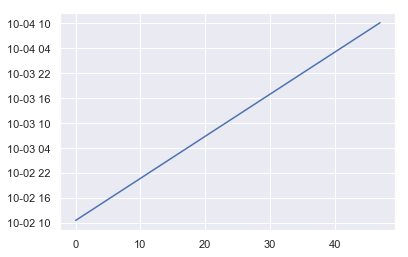

In [38]:
plt.plot(krTimes.timeStamps)

### Event distribution

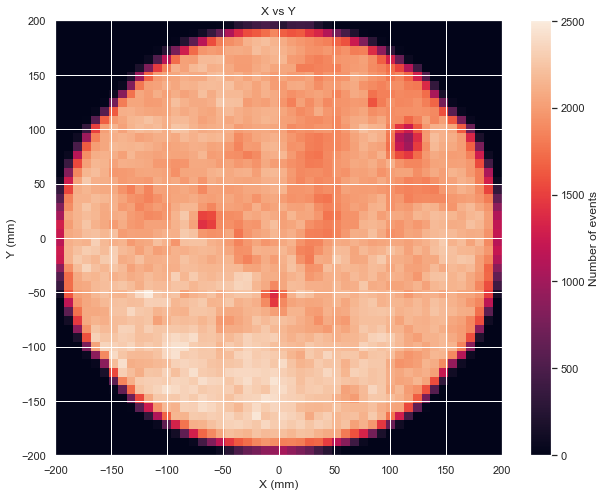

In [39]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Time series

In [40]:
log.setLevel(logging.INFO)

### Divide dst in 100 time series

In [41]:
time_bins = 25
t0 = time.time()

ts, masks = get_time_series(time_bins, DT[-1], kge)  
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.16736316680908203


### Fit lifetime full detector

In [42]:
t0 = time.time()
fps = time_fcs(ts, masks, kge, 
               nbins_z = 15,
               nbins_e = 25,
               range_z = (10, 550),
               range_e = (7000, 14000),
               energy  = 'S2e',
               fit     = FitType.profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 1.0976440906524658


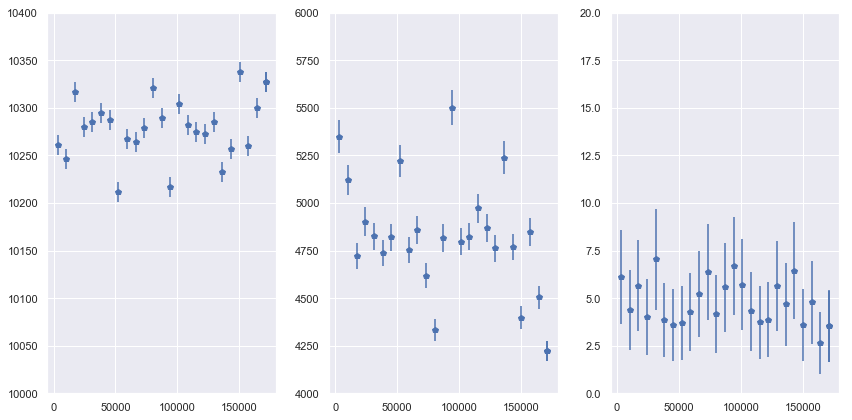

In [43]:
plot_time_fcs(fps,
              range_chi2  = (0,20),
              range_e0    = (10000,10400),
              range_lt    = (4000, 6000),
              figsize     = (12,6))

## Lifetime in RPhi

In [44]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [45]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [46]:
W = define_rphi_sectors(rpsmd)

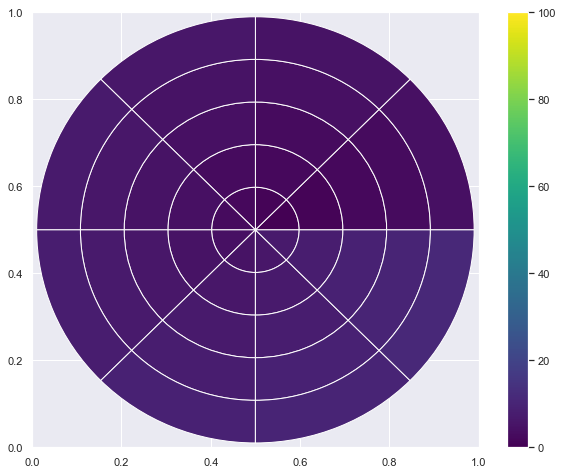

In [47]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [48]:
t0 = time.time()
KSRP = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 5.385336637496948


In [49]:
neM = event_map(KSRP)

In [50]:
neM

,0,1,2,3,4
0,19376,63517,106567,151912,175085
1,20368,62010,109169,159893,174952
2,20901,61574,105748,154407,170474
3,18879,62523,105276,146934,166406
4,19549,57024,99858,129411,158489
5,20133,57307,95848,136466,142984
6,20470,60745,101595,145660,148429
7,19608,56786,100972,141019,160696


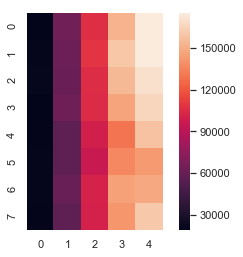

In [51]:
ax = sns.heatmap(neM, square=True)

### four phi sectors: upper half (left-right), lower half (left-right) of chamber

### R < 40 mm

In [52]:
erange = (0,13000)
ltrange = (0, 7000)

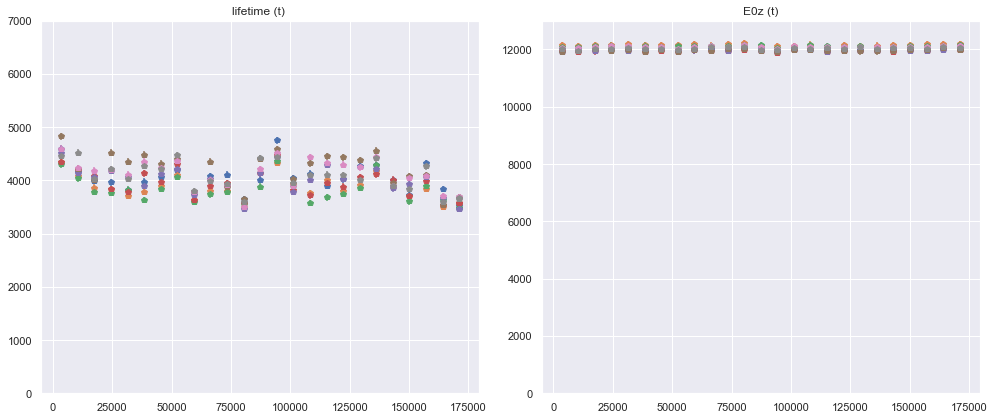

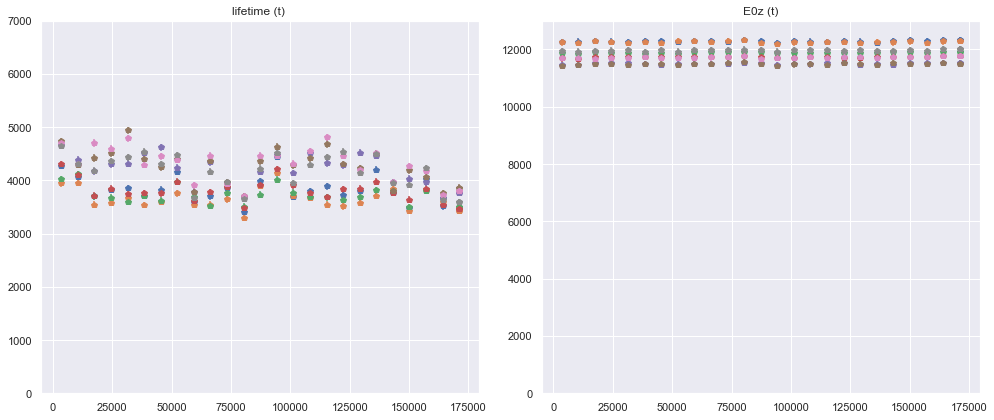

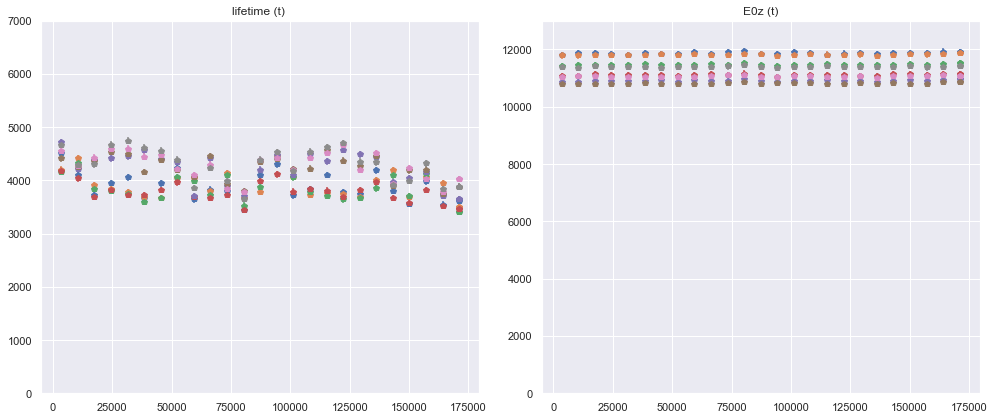

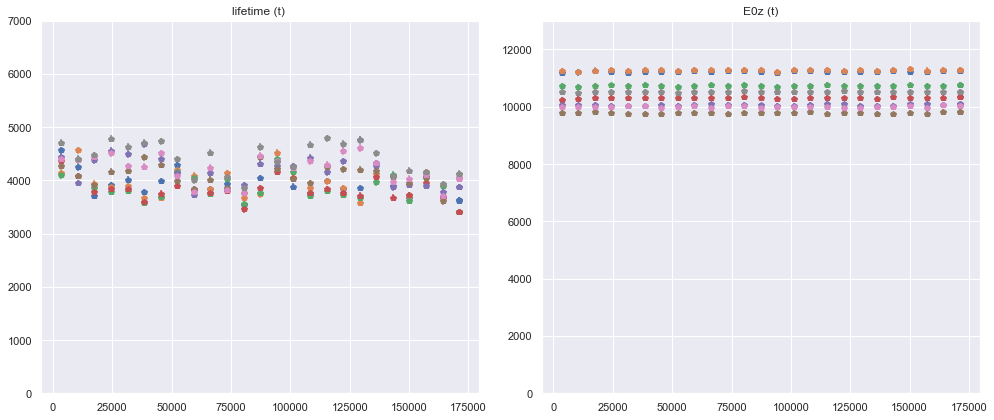

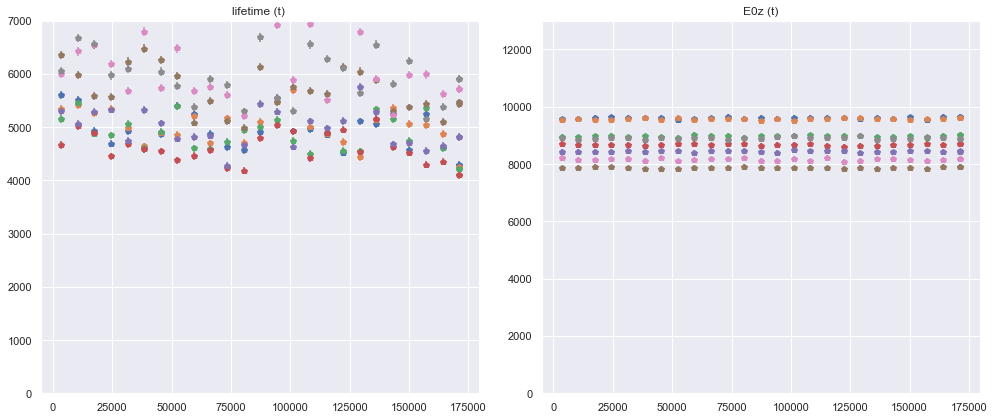

In [53]:
for sector in range(NSECTORS):
    fps = fit_fcs_in_rphi_sectors(sector = sector,
                              selection_map = KSRP,
                              event_map     = neM,
                              n_time_bins   = time_bins,
                              time_diffs    =DT,
                              nbins_z       = 25,
                              nbins_e       = 50,
                              range_z       =(50, 550),
                              range_e       = (5000, 13500),
                              energy        = 'S2e',
                              fit           = FitType.unbined,
                              n_min         = 100)
    plot_fit_sectors(fps,  range_e0 =erange, range_lt=ltrange)
    

### Lifetime patterns:

- Oscillatory pattern in time with a swing of 1 ms!
- Lifetime changes also as a function of Phi, with differences that increase as R increases.
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

### Strategy

- Try to correct geometrical effects first. Fine grained geometrical map with a single time bin.
- Study time dependence later

## Divide chamber in sectors of XY

In [54]:
log.setLevel(logging.DEBUG)

In [55]:
t0 = time.time()
KRES = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

2018-10-26 16:21:43,377 | DEBUG :  function: select_xy_sectors
2018-10-26 16:21:43,378 | DEBUG :  calling selection_mask
2018-10-26 16:21:43,379 | DEBUG : computing selection mask for sector 0
2018-10-26 16:21:43,763 | DEBUG : computing selection mask for sector 1
2018-10-26 16:21:44,150 | DEBUG : computing selection mask for sector 2
2018-10-26 16:21:44,530 | DEBUG : computing selection mask for sector 3
2018-10-26 16:21:44,908 | DEBUG : computing selection mask for sector 4
2018-10-26 16:21:45,308 | DEBUG : computing selection mask for sector 5
2018-10-26 16:21:45,752 | DEBUG : computing selection mask for sector 6
2018-10-26 16:21:46,614 | DEBUG : computing selection mask for sector 7
2018-10-26 16:21:47,134 | DEBUG : computing selection mask for sector 8
2018-10-26 16:21:47,612 | DEBUG : computing selection mask for sector 9
2018-10-26 16:21:48,046 | DEBUG : computing selection mask for sector 10
2018-10-26 16:21:48,462 | DEBUG : computing selection mask for sector 11
2018-10-26 16

In [56]:
log.setLevel(logging.INFO)

In [57]:
neM = event_map(KRES)

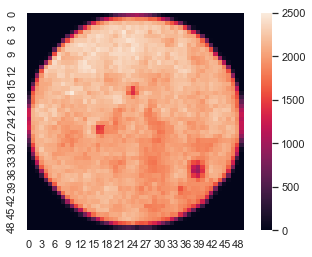

In [58]:
ax = sns.heatmap(neM, square=True)

## Fits in XY sectors

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [59]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy(selection_map = KRES,
                       event_map     = neM,
                       n_time_bins   = 1,
                       time_diffs    = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 100)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 6.682937860488892


In [60]:
times = fpmxy[0][0].ts

In [61]:
times

[87311.0]

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [62]:
tsm = tsmap_from_fmap(fpmxy)

<ErrorbarContainer object of 3 artists>

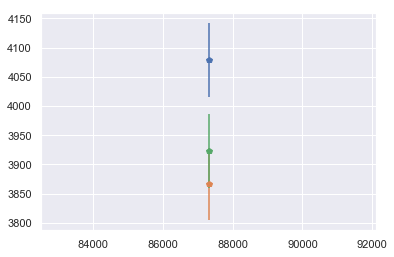

In [63]:
plt.errorbar(times, tsm.lt[25][25], np.sqrt(tsm.lt[25][25]), fmt="p")
plt.errorbar(times, tsm.lt[25][21], np.sqrt(tsm.lt[25][21]), fmt="p")
plt.errorbar(times, tsm.lt[25][22], np.sqrt(tsm.lt[25][22]), fmt="p")

<ErrorbarContainer object of 3 artists>

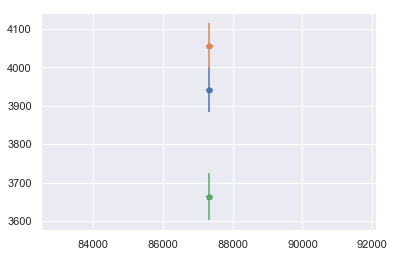

In [64]:
plt.errorbar(times, tsm.lt[30][10], np.sqrt(tsm.lt[6][10]), fmt="p")
plt.errorbar(times, tsm.lt[30][11], np.sqrt(tsm.lt[6][11]), fmt="p")
plt.errorbar(times, tsm.lt[30][12], np.sqrt(tsm.lt[6][12]), fmt="p")

### Obtain amap from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame
```
 

#### There is a single time series (ts = 0)

In [65]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [66]:
amap_average(am) 

ASectorMap(chi2=0.9473278105951717, e0=10008.617847418347, lt=3866.836176884535, e0u=18.120580704192577, ltu=94.42483550614551)

#### Get rid of outlayers that distort mean and error

In [67]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2018-10-26 16:22:44,532 | INFO :  set nans to average value of interval = 9500.0
2018-10-26 16:22:44,585 | INFO :  set nans to average value of interval = 3500.0


In [68]:
amap_average(rmap)

ASectorMap(chi2=0.9473278105951717, e0=10008.617847418347, lt=3864.5195260955725, e0u=18.120580704192577, ltu=93.11892000562622)

In [69]:
asm = relative_errors(rmap)

In [70]:
amv = amap_average(asm)
amv

ASectorMap(chi2=0.9473278105951717, e0=10008.617847418347, lt=3864.5195260955725, e0u=0.1942230299083242, ltu=2.4852565167031613)

#### Draw the maps using default colormap

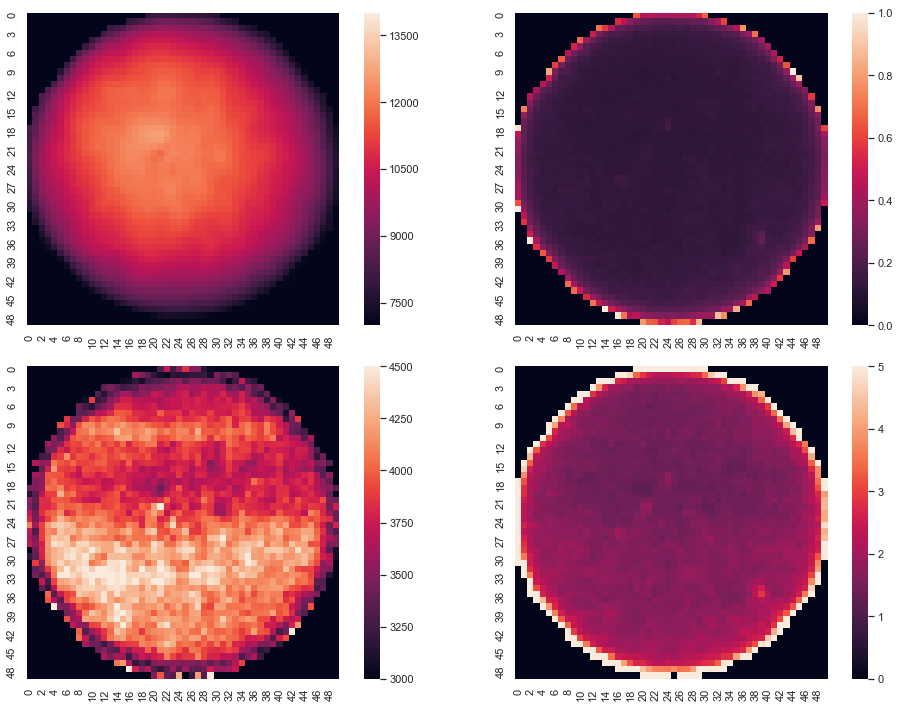

In [71]:
draw_xy_maps(asm,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [72]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [73]:
amap_average(asmAv)

ASectorMap(chi2=0.9369061304937004, e0=10185.177278397763, lt=3892.545896378019, e0u=0.18297636519673044, ltu=2.3266567024559124)

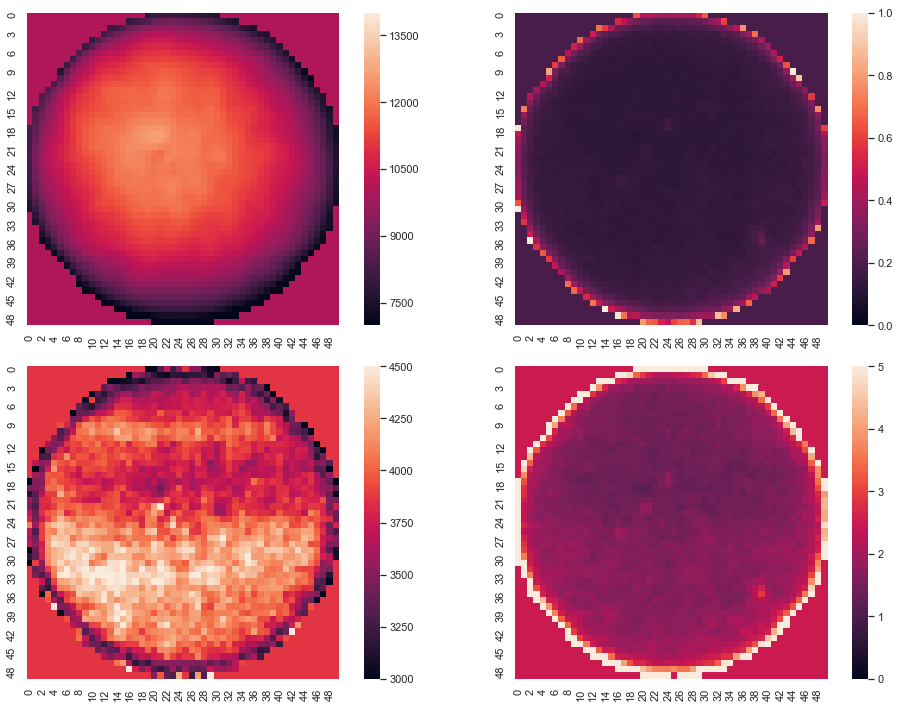

In [74]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

### Save to file

In [75]:
write_maps(asmAv, filename=fn.emap_file_name)

### Read back

In [76]:
emaps = read_maps(filename=fn.emap_file_name)

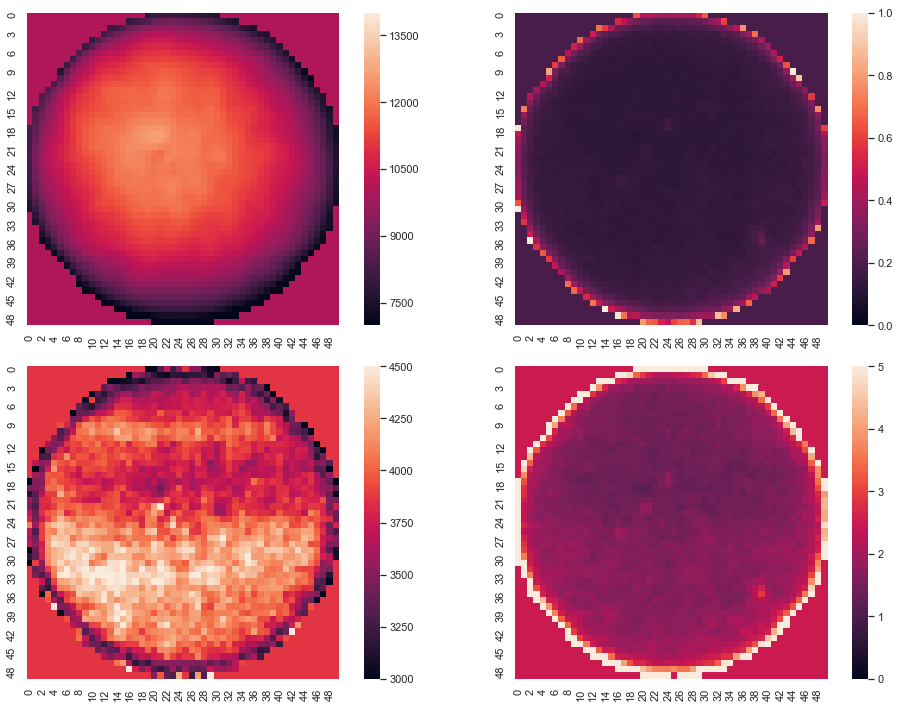

In [77]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [78]:
amap_average(emaps)

ASectorMap(chi2=0.9369061304937004, e0=10185.177278397763, lt=3892.545896378019, e0u=0.18297636519673044, ltu=2.3266567024559124)

In [79]:
norm = amap_max(emaps)

In [80]:
norm

ASectorMap(chi2=4.019769702979967, e0=12657.548188910107, lt=5963.369877219201, e0u=1.1423931962494367, ltu=33.859884270240876)

In [81]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 36.9663770198822


In [82]:
t0 = time.time()
KRP = select_rphi_sectors(dst, DT, E0, dst.S2q, W)
t1 = time.time()
print(f' KRP: t = {t1 -t0}')

 KRP: t = 4.896147012710571


In [83]:
neM = event_map(KRP)

In [84]:
neM

,0,1,2,3,4
0,19376,63517,106567,151912,175085
1,20368,62010,109169,159893,174952
2,20901,61574,105748,154407,170474
3,18879,62523,105276,146934,166406
4,19549,57024,99858,129411,158489
5,20133,57307,95848,136466,142984
6,20470,60745,101595,145660,148429
7,19608,56786,100972,141019,160696


In [85]:
neM[0]

0    19376
1    20368
2    20901
3    18879
4    19549
5    20133
6    20470
7    19608
Name: 0, dtype: int64

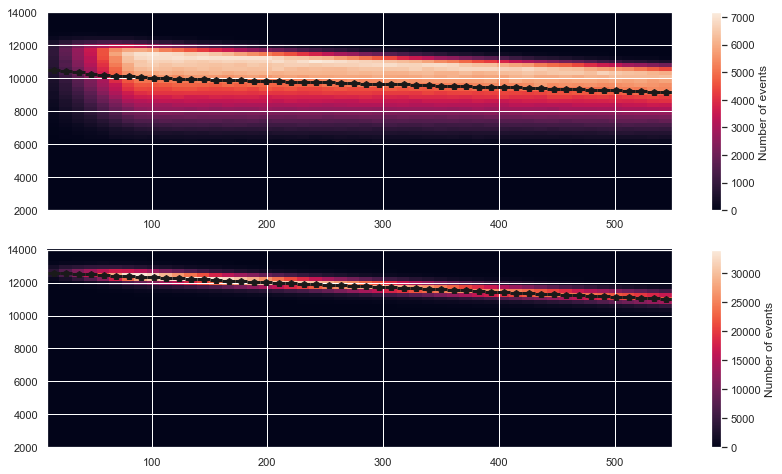

In [86]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

### Now compute maps in rphi.

In [87]:
t0 = time.time()
fmap = fit_map_rphi(selection_map    = KRP,
                       event_map     = neM,
                       n_time_bins   = time_bins,
                       time_diffs     = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy         = 'S2e',
                       fit            = FitType.unbined,
                       n_min          = 100)
t1 = time.time()
print(f' fmap: t = {t1 -t0}')

 fmap: t = 4.257342338562012


In [88]:
tsm = tsmap_from_fmap(fmap)

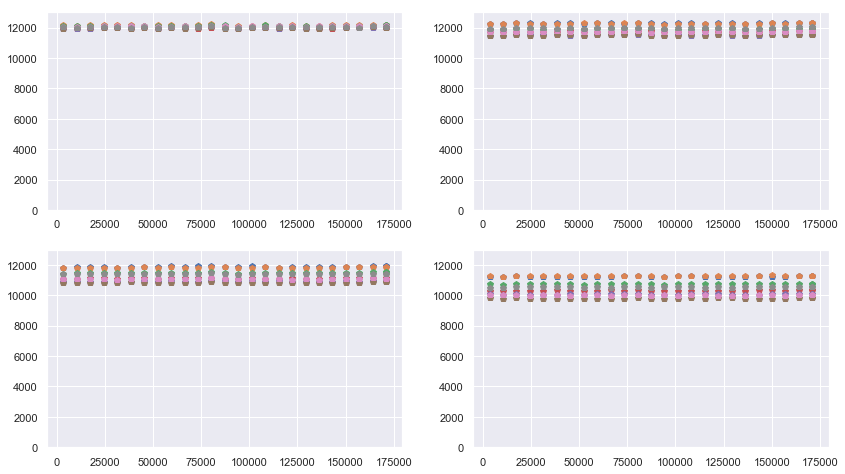

In [89]:
erange=(0, 13000)
fig = plt.figure(figsize=(14,8))
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    plt.ylim(erange)
    for i in neM.index:
        plt.errorbar(ts, tsm.e0[j][i], np.sqrt(tsm.e0[0][i]), fmt="p")

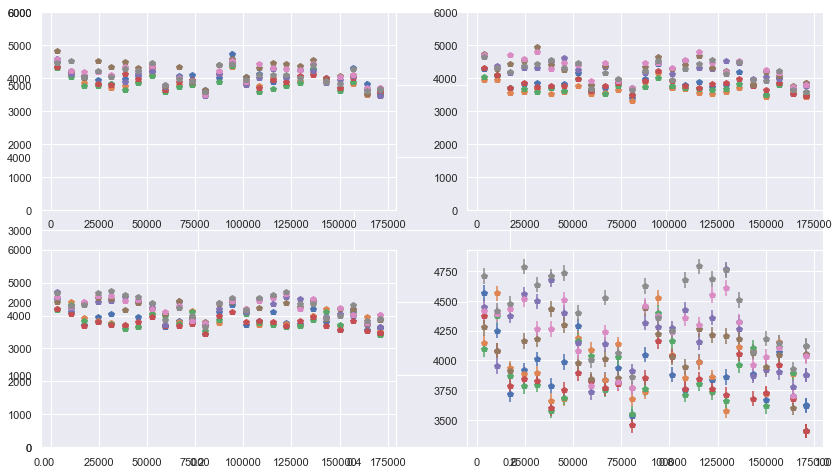

In [90]:
fig = plt.figure(figsize=(14,8))
ltrange=(0, 6000)
for j in range(0,4):
    plt.ylim(ltrange)
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsm.lt[j][i], np.sqrt(tsm.lt[0][i]), fmt="p")
#

In [91]:
t0 = time.time()
fmap2 = fit_map_rphi(selection_map    = KRP,
                       event_map     = neM,
                       n_time_bins   = time_bins,
                       time_diffs     = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy         = 'E',
                       fit            = FitType.unbined,
                       n_min          = 100)
t1 = time.time()
print(f' fmap: t = {t1 -t0}')

 fmap: t = 4.076884031295776


In [92]:
tsm2 = tsmap_from_fmap(fmap2)

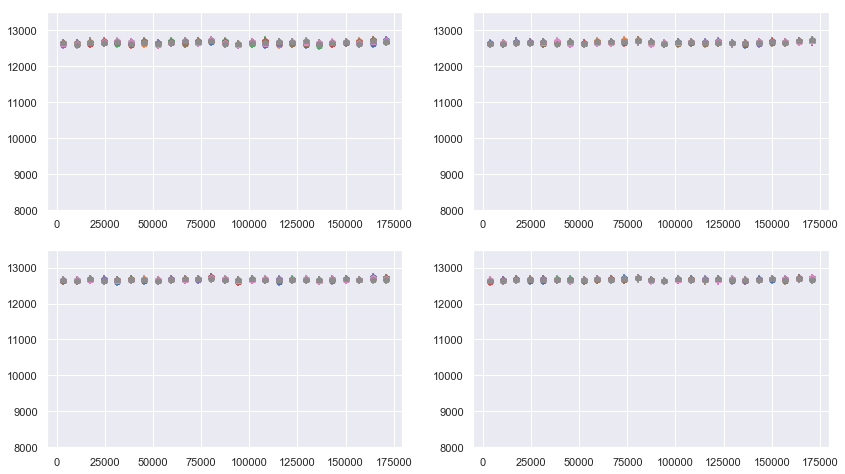

In [93]:
erange=(8000, 13500)
fig = plt.figure(figsize=(14,8))
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    plt.ylim(erange)
    for i in neM.index:
        plt.errorbar(ts, tsm2.e0[j][i], np.sqrt(tsm2.e0[0][i]), fmt="p")

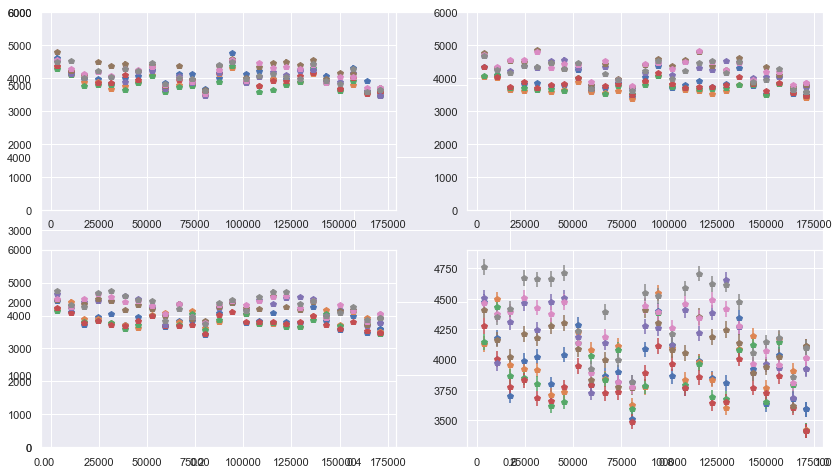

In [94]:
fig = plt.figure(figsize=(14,8))
ltrange=(0, 6000)
for j in range(0,4):
    plt.ylim(ltrange)
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsm2.lt[j][i], np.sqrt(tsm2.lt[0][i]), fmt="p")

In [95]:
amts0 = amap_from_tsmap(tsm2, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [96]:
avam = amap_average(amts0) 
avam

ASectorMap(chi2=0.9682281182434924, e0=12625.108711022407, lt=4358.822797339492, e0u=15.380892096192294, ltu=70.2239251572415)

In [97]:
asm0 = relative_errors(amts0)

In [98]:
amap_average(asm0) 

ASectorMap(chi2=0.9682281182434924, e0=12625.108711022407, lt=4358.822797339492, e0u=0.12182835850480914, ltu=1.6013422424057064)

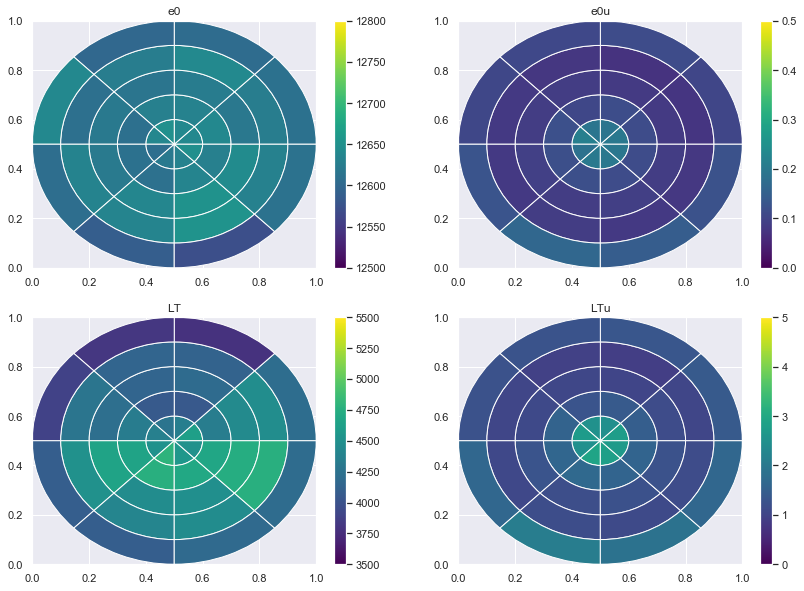

In [99]:
draw_rphi_maps(W, asm0,  
          e0lims  = (12500, 12800),
          ltlims  = (3500, 5500),
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

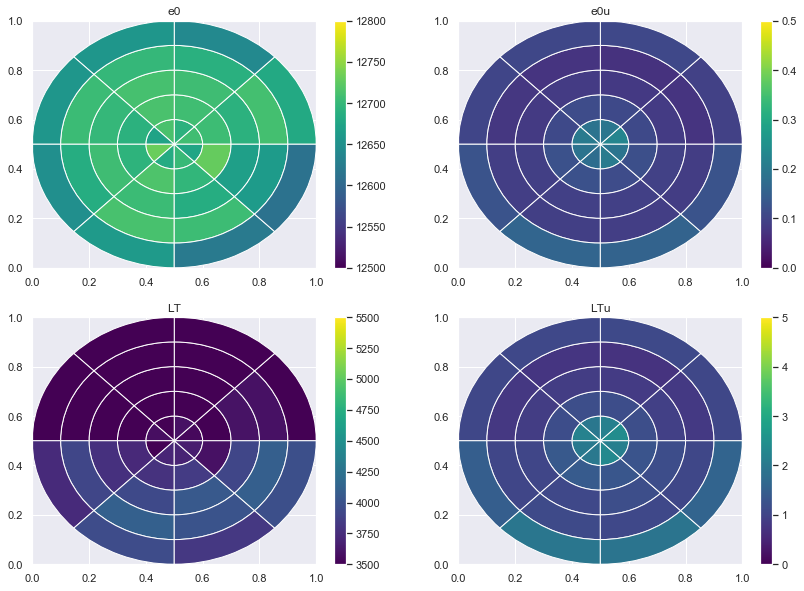

In [100]:
amts50 = amap_from_tsmap(tsm2, 
                     ts = 25, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
asm50 = relative_errors(amts50)
amap_average(asm50) 
draw_rphi_maps(W, asm50,  
          e0lims  = (12500, 12800),
          ltlims  = (3500, 5500),
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

### Maps for the full time series

In [101]:
aMaps = []
EE    = []
LT    = []
TT    = []
t0 = time.time()
for i, tt in enumerate(ts):
    am = amap_from_tsmap(tsm2, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,100),
                         range_lt    = (3000,5000))
    amv = amap_average(am) 
    asm = relative_errors(am)
    av = amap_replace_nan_by_mean(asm, amMean=amv)
    av0 = amap_average(av) 
    aMaps.append(av)
    EE.append(av0.e0)
    LT.append(av0.lt)
    TT.append(tt)
t1 = time.time()
print(f' t = {t1 -t0}')

 t = 0.14501619338989258


(0, 13500)

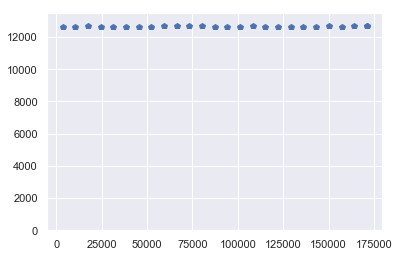

In [102]:
plt.errorbar(TT, EE, 10, fmt="p")
plt.ylim(0,13500)

(0, 5000)

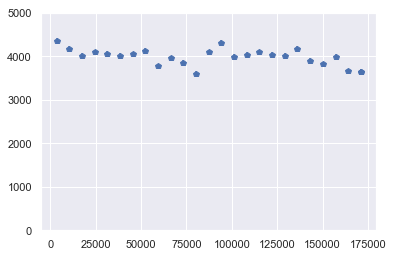

In [103]:
plt.errorbar(TT, LT, sqrt(LT), fmt="p")
plt.ylim(0,5000)

### Write maps

In [104]:
fn.map_file_name_ts

'/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_5_8_ts_25_6350_6353.h5'

In [105]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)

### Read maps

In [106]:
tts, tsMaps = read_maps_ts(fn.map_file_name_ts)

In [107]:
kdst = kr_event(dst, DT, E0, dst.S2q)
fr = RMAX / NSECTORS 

In [108]:
t0 = time.time()
kge =  e0_rphi_correction_ts(kdst, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' E0 correction: t = {t1 -t0}')

 E0 correction: t = 18.418813943862915


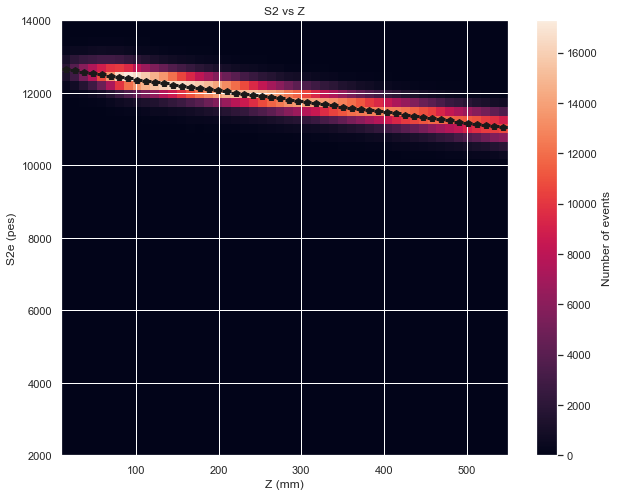

In [109]:
nevt = h2d(kge.Z, kge.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [110]:
t0 = time.time()
klt1 =  lt_rphi_correction_ts(kdst, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 18.410663843154907


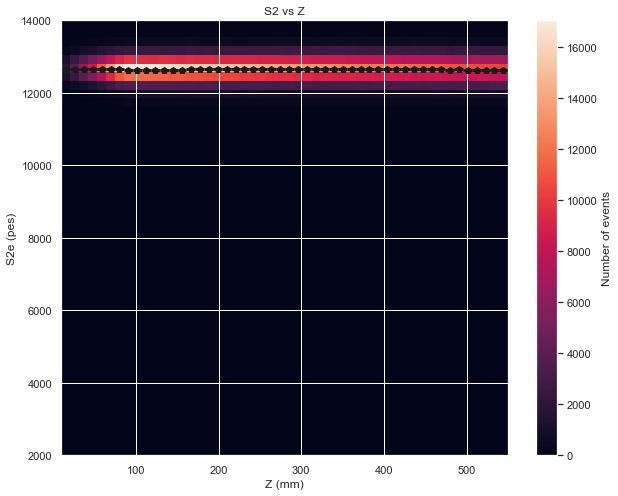

In [111]:
nevt = h2d(klt1.Z, klt1.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [112]:
t0 = time.time()
klt =  lt_rphi_correction_ts(kge, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 17.243644952774048


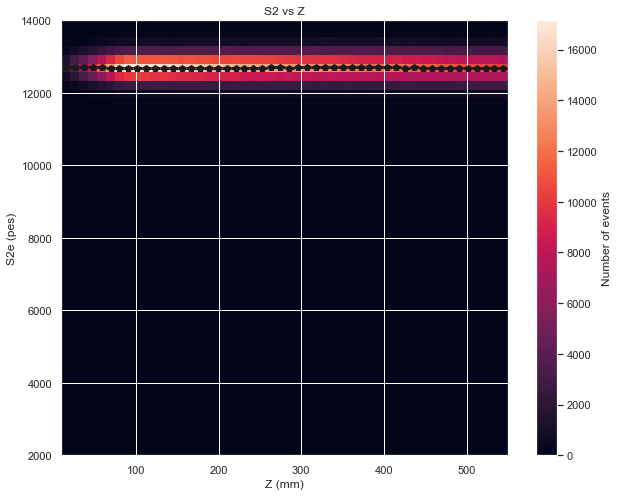

In [113]:
nevt = h2d(klt.Z, klt.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

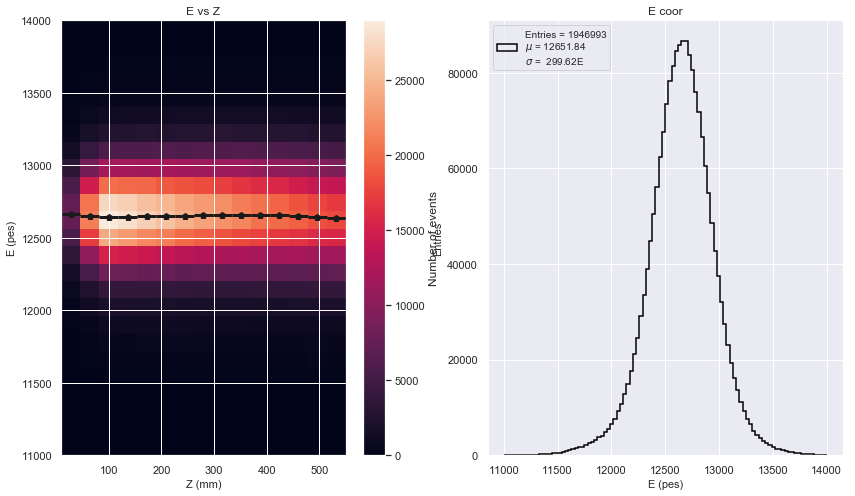

In [114]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(klt1.Z, klt1.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(klt1.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12659.996306605859 +-0.2064668613385002 
 E sigma   = 273.0099350848212 +-0.16996148374417427 
 chi2    = 6.531396903129637 
 sigma E/E (FWHM)     (%) =5.067721442498079
 sigma E/E (FWHM) Qbb (%) =0.6545061385054481 


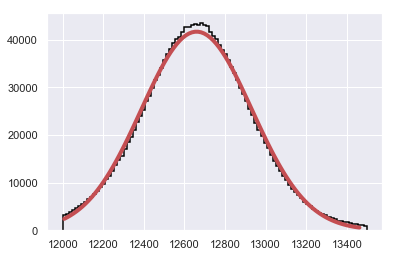

In [115]:
fc = fit_energy(klt1.E, nbins=100, range=(12000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

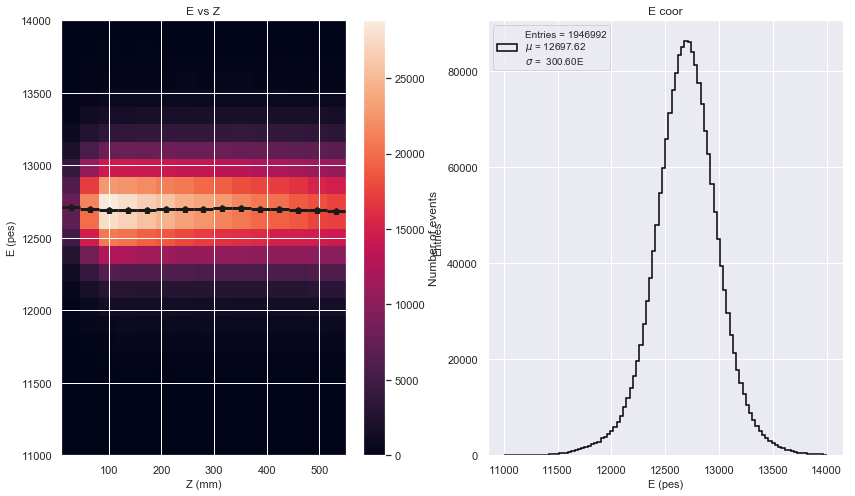

In [116]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(klt.Z, klt.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(klt.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12702.6180721112 +-0.2068786359635694 
 E sigma   = 276.0336794447316 +-0.16946976715843234 
 chi2    = 6.919478351281514 
 sigma E/E (FWHM)     (%) =5.1066570923619645
 sigma E/E (FWHM) Qbb (%) =0.659534753856897 


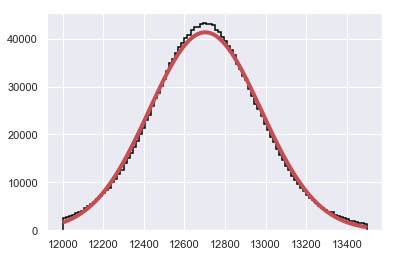

In [117]:
fc = fit_energy(klt.E, nbins=100, range=(12000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

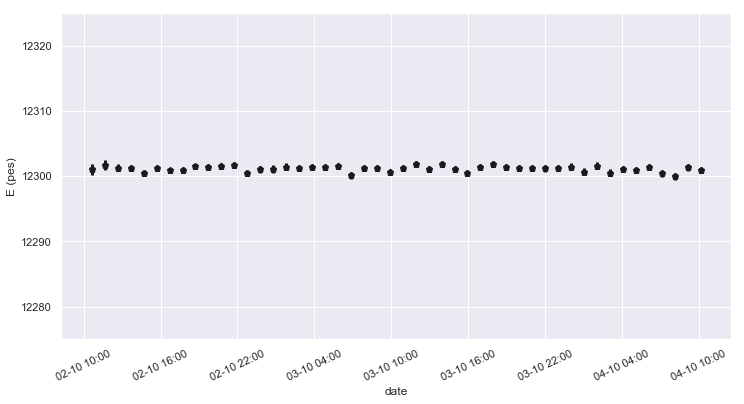

In [118]:
baseline = 12300
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(klt.T, klt.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12275, 12325),
                    figsize=(12,6))

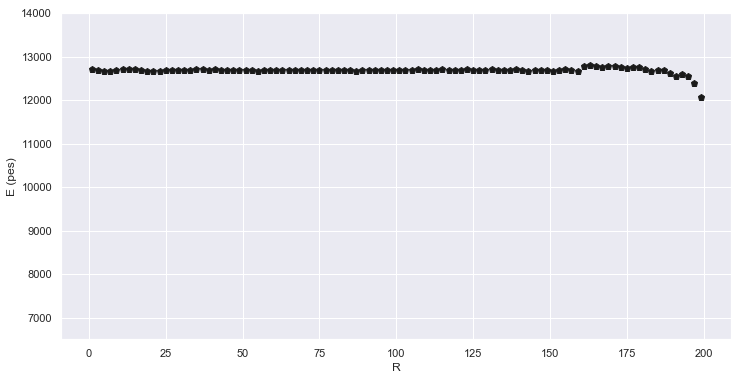

In [119]:
energy_X_profile(klt.R, klt.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

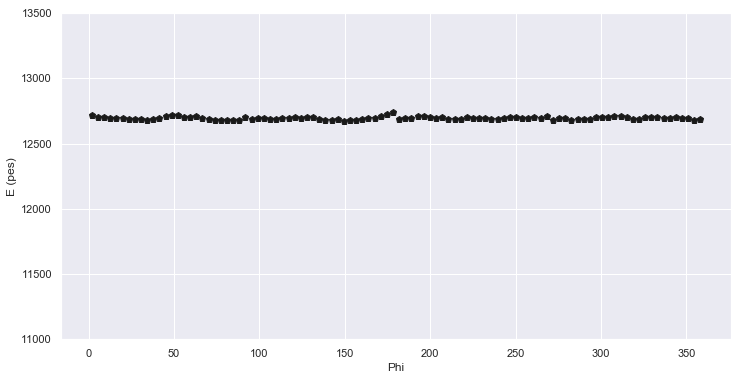

In [120]:
energy_X_profile(phirad_to_deg(klt.Phi), klt.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

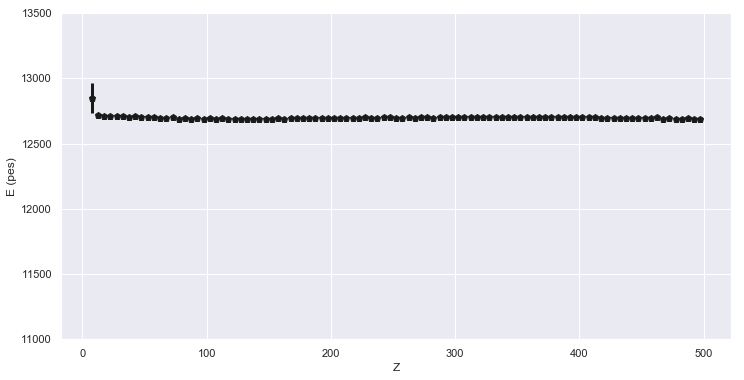

In [121]:
energy_X_profile(klt.Z, klt.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

(11000, 13500)

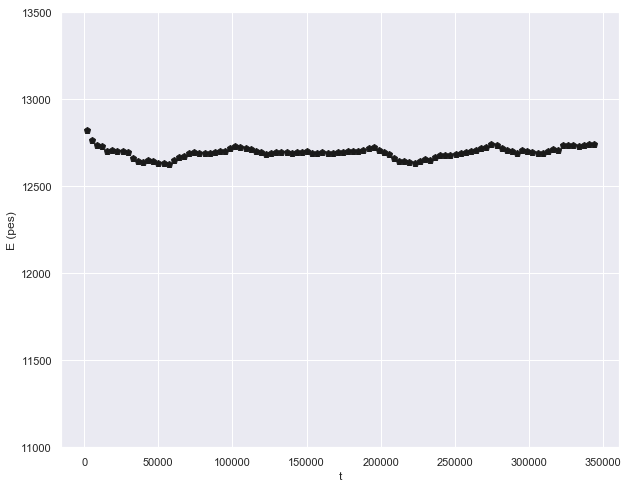

In [122]:
T   =(klt.T - klt.T.min()) 
t, e, eu = fitf.profileX(T, klt.E, 100)
erange =(11000, 13500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [123]:
e_mu    = np.nanmean(klt.E)
print(e_mu)
e_std   = np.nanstd (klt.E)
print(e_std)

12696.432111843415
313.1588548129864


In [124]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = klt.E * ET_correction(T).value

(11000, 13500)

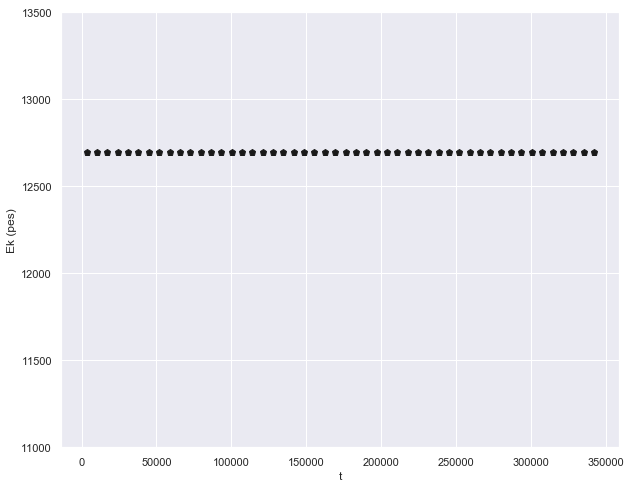

In [125]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

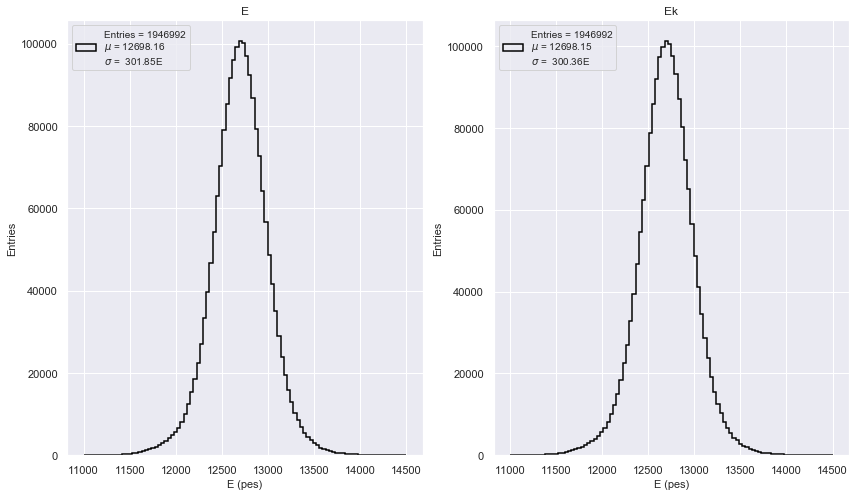

In [126]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(klt.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Ek'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12702.730932442886 +-0.20545850884440228 
 E sigma   = 274.4826514359113 +-0.16804551945547963 
 chi2    = 10.36611127965827 
 sigma E/E (FWHM)     (%) =5.077917766698249
 sigma E/E (FWHM) Qbb (%) =0.6558230137234187 


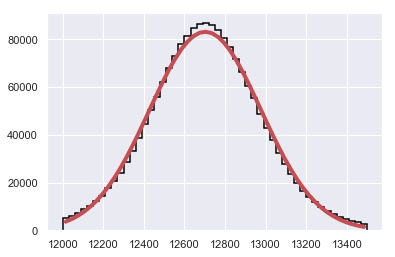

In [127]:
fc = fit_energy(Ek, nbins=50, range=(12000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

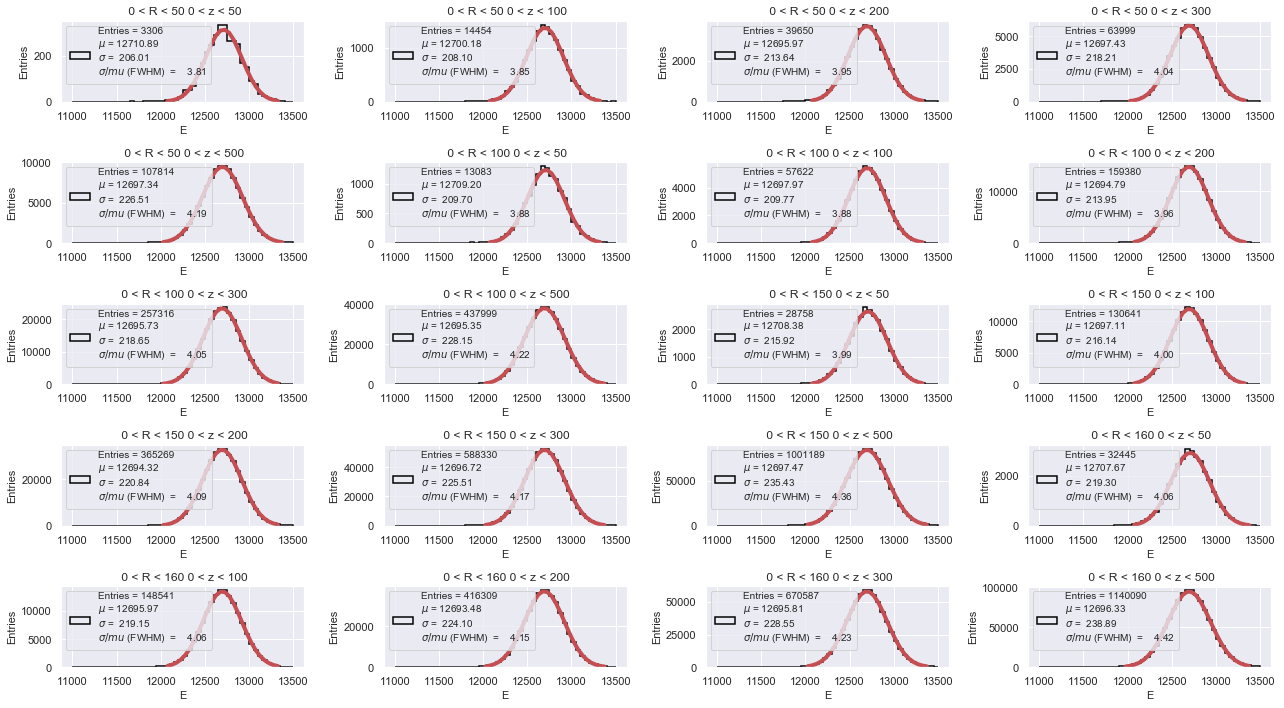

In [128]:
Ri = (50, 100,150,160)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, klt.R, klt.Z, Ek,
                    enbins = 50,
                    erange = (11e+3, 13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

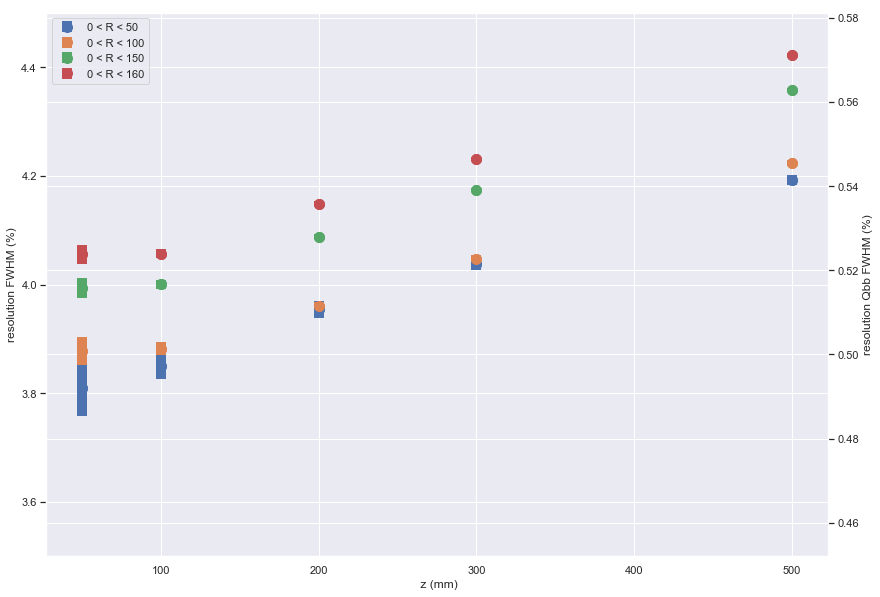

In [129]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

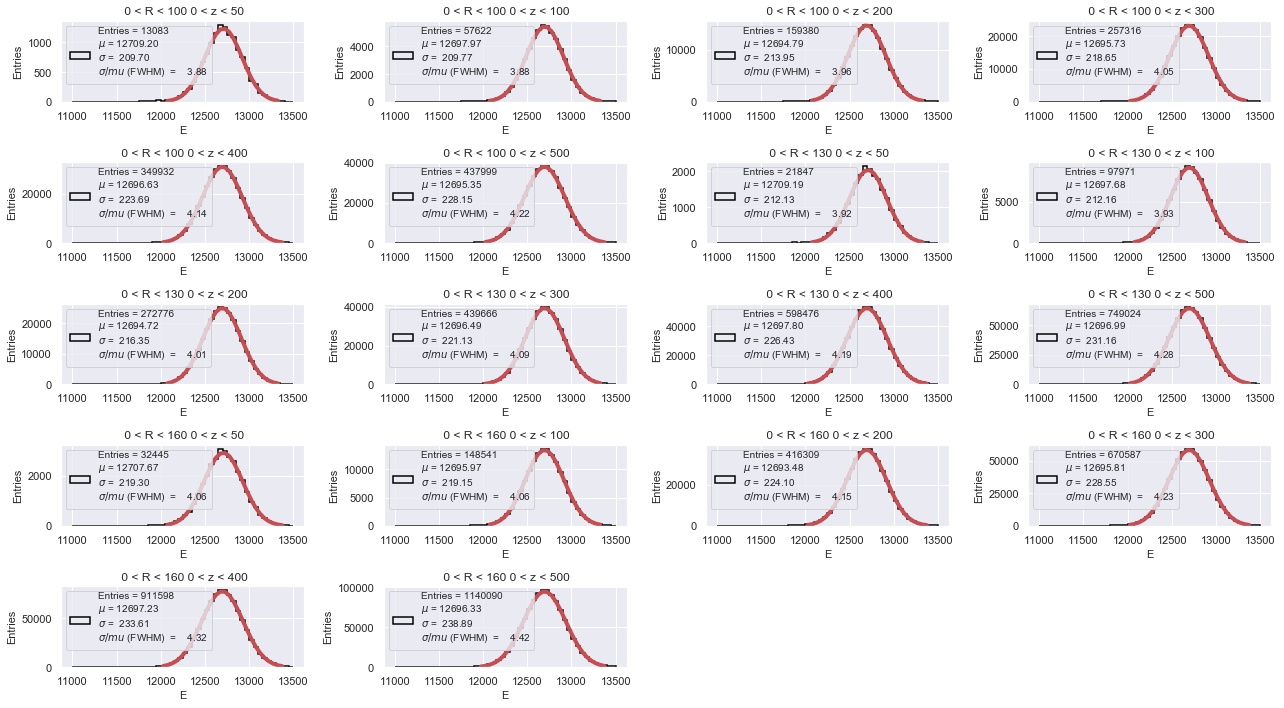

In [130]:
Ri = (100,130,160)
Zi = (50, 100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, klt.R, klt.Z, Ek,
                    enbins = 50,
                    erange = (11e+3, 13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

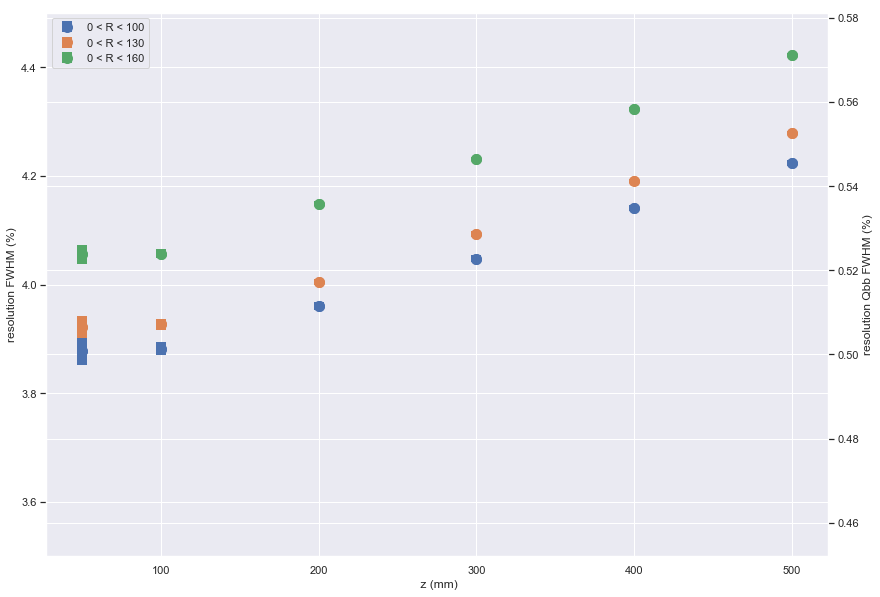

In [131]:
plot_resolution_r_z(Ri, Zi, FC, FCE)